In [19]:
from feature_engineering import generate_features
from get_data import get_raw_data
import pandas as pd
from feature_engineering import get_sp_500_data

In [20]:
from datetime import datetime
from packaging import version
import tensorflow as tf
from tensorflow import keras
from keras import backend as K



print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, \
    "This notebook requires TensorFlow 2.0 or above."


TensorFlow version:  2.15.0


In [21]:
data=generate_features(get_raw_data('TSLA'))


[*********************100%%**********************]  1 of 1 completed


In [22]:
data.head(-10)


,open,open_1,close_1,high_1,low_1,volume_1,avg_price_5,avg_price_30,avg_price_365,ratio_avg_price_5_30,...,ratio_std_volume_5_365,ratio_std_volume_30_365,return_1,return_5,return_30,return_365,moving_avg_5,moving_avg_30,moving_avg_365,close
Date,,,,,,,,,,,,,,,,,,,,,
2021-09-10,253.199997,251.136673,251.619995,254.033340,250.543335,42233100.0,248.507330,238.241905,211.371071,1.043088,...,0.144253,0.176977,0.001313,0.028293,0.063198,1.060882,0.032384,0.059679,4.521669,245.423340
2021-09-13,246.736664,253.199997,245.423340,254.203339,244.839996,45552600.0,248.765997,238.693492,211.853783,1.042198,...,0.121335,0.164318,-0.024627,0.005298,0.040194,0.982738,0.031605,0.061001,4.498992,247.666672
2021-09-14,247.523331,246.736664,247.666672,248.259995,236.283340,68857500.0,249.394666,239.022858,212.343571,1.043393,...,0.170012,0.176476,0.009141,0.012855,0.028730,0.993454,0.023757,0.060118,4.477043,248.163330
2021-09-15,248.333328,247.523331,248.163330,251.490005,245.466660,55574700.0,248.832666,239.456508,212.773294,1.039156,...,0.165397,0.178744,0.002005,-0.011196,0.038094,0.774200,0.020246,0.056466,4.454876,251.943329
2021-09-16,250.943329,248.333328,251.943329,252.286667,246.119995,46073100.0,248.963333,240.562222,213.178148,1.034923,...,0.173805,0.171650,0.015232,0.002600,0.101520,0.680518,0.011984,0.053408,4.427961,252.330002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-17,157.639999,156.740005,157.110001,158.190002,153.750000,97000000.0,167.200000,171.545239,221.517579,0.974670,...,0.558953,0.753186,-0.027062,-0.111771,-0.039494,-0.150757,0.014559,-0.085416,0.056078,155.449997
2024-04-18,151.250000,157.639999,155.449997,158.330002,153.779999,82439700.0,163.938000,170.671430,221.392222,0.960547,...,0.563034,0.743554,-0.010566,-0.094958,-0.105581,-0.168894,-0.020097,-0.080953,0.057217,149.929993
2024-04-19,148.970001,151.250000,149.929993,152.199997,148.699997,96098800.0,159.003998,169.652857,221.255793,0.937231,...,0.571020,0.732984,-0.035510,-0.141294,-0.124854,-0.186534,-0.043104,-0.079649,0.058337,147.050003


In [23]:
data.shape

(668, 38)

In [24]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from keras.models import Sequential
from keras.layers import  LSTM, Dense,Dropout


In [25]:
# here we are seperating the data 
trainning_set = data[:'2024-03-01'].iloc[:,1:2].values
test_set = data['2024-03-01':].iloc[:,1:2].values

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = scaler.fit_transform(trainning_set)


X_train = []
Y_train = []


for i in range(1, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-1:i, 0])
    Y_train.append(training_set_scaled[i, 0])

# Convert lists to NumPy arrays
X_train, y_train = np.array(X_train), np.array(Y_train)

# Reshape X_train for LSTM input shape (batch_size, timesteps, input_dim)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [26]:
X_train.shape

(621, 1, 1)

In [27]:

# pre-processing the data 
dataset_total = pd.concat((data["close"][:'2024-03-01'],data["close"]['2024-03-01':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 500:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

# making the test data
X_test = []
for i in range(500,len(inputs)):
  X_test.append(inputs[i-1:i,0])

X_test_no_shape = np.array(X_test)
X_test = np.reshape(X_test_no_shape, (X_test_no_shape.shape[0],X_test_no_shape.shape[1],1))


test_set=scaler.transform(test_set)

test_set.shape

(47, 1)

In [28]:
def mae(y_predicted, y_true):
    total_error = 0
    for yp, yt in zip(y_predicted, y_true):
        total_error += abs(yp - yt)
    
    mae = total_error/len(y_predicted)
    
    return mae

Best h-params : DROP [0.3,0.1,0.1,0.1] UNITS[32,32,64,32]

In [29]:
model = Sequential()

model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.2))

model.add(LSTM(units=128,return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=64))
model.add(Dropout(0.2))

model.add(Dense(units=64))
model.add(Dropout(0.2))

model.add(Dense(units=32))
model.add(Dropout(0.2))

model.add(Dense(units=1))



In [30]:

METRICS = [
    keras.metrics.MeanAbsoluteError(name='mae'),
    tf.keras.metrics.RootMeanSquaredError(name='rmse'),
    keras.metrics.MeanSquaredError(name='mse'),
]

In [31]:
tf.random.set_seed(21)

logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")+"FULL"
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)


                        
model.compile(loss='mean_squared_error',optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),metrics=METRICS)

callback = keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=10,
    restore_best_weights=True)

model.fit(X_train, y_train, epochs=100,batch_size=32,callbacks=[callback,tensorboard_callback]) 
loss = model.evaluate(X_test, test_set)

Epoch 1/100
20/20 [==============================] - 3s 6ms/step - loss: 0.1134 - mae: 0.2752 - rmse: 0.3367 - mse: 0.1134
Epoch 2/100
20/20 [==============================] - 0s 6ms/step - loss: 0.0386 - mae: 0.1573 - rmse: 0.1966 - mse: 0.0386
Epoch 3/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0287 - mae: 0.1373 - rmse: 0.1695 - mse: 0.0287
Epoch 4/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0146 - mae: 0.0964 - rmse: 0.1207 - mse: 0.0146
Epoch 5/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0073 - mae: 0.0651 - rmse: 0.0854 - mse: 0.0073
Epoch 6/100
20/20 [==============================] - 0s 6ms/step - loss: 0.0058 - mae: 0.0569 - rmse: 0.0765 - mse: 0.0058
Epoch 7/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0075 - mae: 0.0640 - rmse: 0.0864 - mse: 0.0075
Epoch 8/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0076 - mae: 0.0638 - rmse: 0.0871 - mse: 0.0076
Epoch 9/100
20/2

In [32]:
predicted_stock_price = model.predict(X_test)


predicted_stock_price = scaler.inverse_transform(predicted_stock_price)
test_set=scaler.inverse_transform(test_set)


2/2 [==============================] - 1s 3ms/step


In [33]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score,mean_absolute_error

print(f"MSE: {mean_squared_error(test_set,predicted_stock_price)}")
print(f"MRSE: {mean_absolute_error(test_set,predicted_stock_price)}")
print(f"R^2: {r2_score(test_set,predicted_stock_price)}")
print(f"MAE{mean_absolute_error(test_set,predicted_stock_price)}")

MSE: 14.325463272556856
MRSE: 2.8377020003947813
R^2: 0.9134450523508961
MAE2.8377020003947813


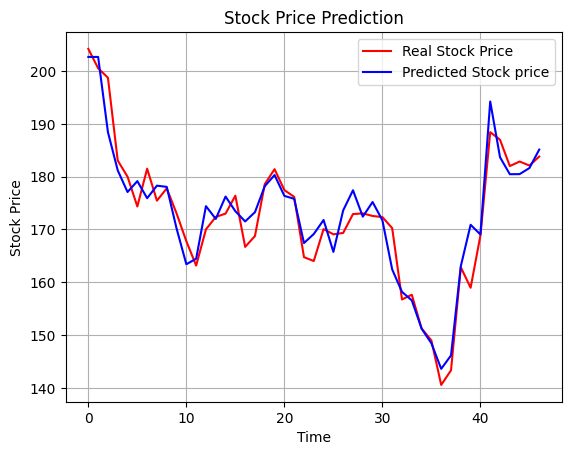

In [34]:
import matplotlib.pyplot as plt

def plot_prediction(test,prediction):
    plt.plot(test,color='red',label="Real Stock Price")
    plt.plot(prediction, color="blue",label="Predicted Stock price")
    plt.title("Stock Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("Stock Price")
    plt.legend()
    plt.grid(True)
    plt.show()
    


plot_prediction(test_set,predicted_stock_price)

In [35]:
print(predicted_stock_price)

[[202.6629 ]
 [202.6629 ]
 [188.42845]
 [181.18762]
 [177.08527]
 [179.14555]
 [175.91415]
 [178.28612]
 [178.06151]
 [170.2016 ]
 [163.41121]
 [164.45116]
 [174.41188]
 [171.99417]
 [176.22643]
 [173.45627]
 [171.5167 ]
 [173.27101]
 [178.18848]
 [180.29832]
 [176.35327]
 [175.79709]
 [167.42717]
 [169.13046]
 [171.78952]
 [165.74428]
 [173.61224]
 [177.41718]
 [172.42297]
 [175.1922 ]
 [171.73106]
 [162.42021]
 [158.17824]
 [156.5685 ]
 [151.22205]
 [148.43658]
 [143.60728]
 [146.14645]
 [163.0517 ]
 [170.8834 ]
 [169.04285]
 [194.22293]
 [183.67114]
 [180.45467]
 [180.47421]
 [181.62749]
 [185.11913]]


In [36]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 1, 128)            66560     
                                                                 
 dropout_5 (Dropout)         (None, 1, 128)            0         
                                                                 
 lstm_4 (LSTM)               (None, 1, 128)            131584    
                                                                 
 dropout_6 (Dropout)         (None, 1, 128)            0         
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 64)               